# Python data manipulation exercise - Airline Performance Analysis

## Problem

Airlines are always run on tight schedules and very thin operating margins. To top this, the customers are extremely demanding expecting their flights to be on time always. Airline carriers try to overcome this challenge by detailed planning and prompt execution. However, there are factors like weather, technical glitches, unexpected challenges at airports which end up causing delay in arrival or departure of aircrafts. Since, the flights hop multiple cities any delay caused at one nodal city adds up and results in significant delays in subsequent stoppages if not taken care of early. 

## What is expected from you?
You have been provided with 3 datasets : 
1. airline-performance.csv
2. air-carrier-details.csv
3. airports.csv

Below are a set of questions of interest related to the problem statement at hand. Leverage your Python data wrangling skills to solve them

In [1]:
file_path = '../../problem-sets/Set-1/data'

In [2]:
# Let us read the datasets first
import pandas as pd
ar_pf = pd.read_csv(file_path+'/airline-performance.csv')
ar_cr = pd.read_csv(file_path+'/air-carrier-details.csv')
arp = pd.read_csv(file_path+'/airports.csv')

In [ ]:
ar_pf.columns

## Question : 1

* Which airline carrier is busiest in terms of volume?

Let's analyze the question here. We need to find out the name of the airline carrier
* Also, busiest in terms of volume would mean calculating count of trips
* As we find out, each row of the dataset airline-performance corresponds to a trip
* This dataset also has reference to airline carrier called **UniqueCarrierCode** and refers to the dataset air-carrier-details which has the name of the carrier in the column **Description**

In [3]:
# Let's first look at sample data in the dataframe ar_cr
ar_cr.head()

,Code,Description
0,19031,Mackey International Inc.: MAC
1,19032,Munz Northern Airlines Inc.: XY
2,19033,Cochise Airlines Inc.: COC
3,19034,Golden Gate Airlines Inc.: GSA
4,19035,Aeromech Inc.: RZZ


In [4]:
# Looking at the data above, it seems the value which is required to join with the datasets ar_pf is a part of 
# the Description column
# We need to extract the letters after the : symbol, which would then be used to join the dataset ar_pf using the 
# column UniqueCarrierCode
# This can be easily done by the below code

ar_cr[['airline_name','airline_code']] = ar_cr['Description'].str.split(':',expand = True)

In [5]:
ar_cr.head()

,Code,Description,airline_name,airline_code
0,19031,Mackey International Inc.: MAC,Mackey International Inc.,MAC
1,19032,Munz Northern Airlines Inc.: XY,Munz Northern Airlines Inc.,XY
2,19033,Cochise Airlines Inc.: COC,Cochise Airlines Inc.,COC
3,19034,Golden Gate Airlines Inc.: GSA,Golden Gate Airlines Inc.,GSA
4,19035,Aeromech Inc.: RZZ,Aeromech Inc.,RZZ


Have a look at the reference [here](https://www.geeksforgeeks.org/split-a-text-column-into-two-columns-in-pandas-dataframe/) to understand the above code

In [6]:
# Just for hygiene purposes we strip off all possible whitespaces from the code
ar_cr['airline_code'] = ar_cr['airline_code'].str.strip()

In [7]:
# Let's now look how the dataframe looks like :
ar_cr.head()

,Code,Description,airline_name,airline_code
0,19031,Mackey International Inc.: MAC,Mackey International Inc.,MAC
1,19032,Munz Northern Airlines Inc.: XY,Munz Northern Airlines Inc.,XY
2,19033,Cochise Airlines Inc.: COC,Cochise Airlines Inc.,COC
3,19034,Golden Gate Airlines Inc.: GSA,Golden Gate Airlines Inc.,GSA
4,19035,Aeromech Inc.: RZZ,Aeromech Inc.,RZZ


In [8]:
# Cool, now all that is left is joining with the ar_pf dataframe on UniqueCarrierCode column
# we do this using merge function of pandas
# Why do we do left join?
dfq1 = pd.merge(ar_pf,ar_cr,left_on='UniqueCarrierCode',right_on='airline_code',how='left')

In [9]:
# Ok, merge is done. Let's see how the new dataframe looks like
dfq1.loc[:0,]

,RowNo,Month,DayofMonth,DayOfWeek,DepTime,ShDepTime,ArrTime,ShArrTime,UniqueCarrierCode,FlightNum,...,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Code,Description,airline_name,airline_code
0,1,9,16,2,1725.0,1730,1857.0,1909.0,CO,1197,...,0,NaN,NaN,NaN,NaN,NaN,19704.0,Continental Air Lines Inc.: CO,Continental Air Lines Inc.,CO


In [10]:
# Just a check to see which all columns have missing values (we just did a left join above)
dfq1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 33 columns):
RowNo                25000 non-null int64
Month                25000 non-null int64
DayofMonth           25000 non-null int64
DayOfWeek            25000 non-null int64
DepTime              24518 non-null float64
ShDepTime            25000 non-null int64
ArrTime              24464 non-null float64
ShArrTime            24995 non-null float64
UniqueCarrierCode    25000 non-null object
FlightNum            25000 non-null int64
TailNum              24705 non-null object
ActualElapsedTime    24451 non-null float64
ShElapsedTime        24998 non-null float64
AirTime              24451 non-null float64
ArrDelay             24418 non-null float64
DepDelay             24508 non-null float64
OriginCode           25000 non-null object
DestCode             25000 non-null object
Distance             24994 non-null float64
TaxiIn               24464 non-null float64
TaxiOut              24516 

In [11]:
# Let's set missing values in airline_name column with NA
dfq1['airline_name'].fillna('NA',inplace = True)
# Why inplace = True above?
# Because fillna function without inplace = True does not replace the actual data in the dataframe. 
# For the fillna function to take effect inplace = True needs to be supplied

In [12]:
# Now, we can group by airline_name
# take count of rows using the size function
# sort the data by the count
# and slice out the top row
dfq1.groupby('airline_name').size().sort_values(ascending=False)[:1]

airline_name
Southwest Airlines Co.    4297
dtype: int64

In [13]:
# Let's store the name and value separately (of the top most airline)
airline_name = dfq1.groupby('airline_name').size().sort_values(ascending=False).index[0]
value = dfq1.groupby('airline_name').size().sort_values(ascending=False).values[0]

In [14]:
# Let's print the final result in a readable format
print("Airline %s is the busiest in terms of volume having trip count = %d"%(airline_name,value))

Airline Southwest Airlines Co. is the busiest in terms of volume having trip count = 4297


## Question : 2

* Which city is busiest in terms of traffic?
    * Please note that you need to print out the city names against the traffic number and not just the airport name
    * Ex. an airport name entry looks like : **New York, NY: John F Kennedy International**. The city name from this entry is **New York** 

In [15]:
# Step 1 : Take count of trips by source city = This gives the departure count by city
df_dep = dfq1.groupby('OriginCode').size()
print(type(df_dep))
df_dep[:3]

<class 'pandas.core.series.Series'>


OriginCode
ABE     13
ABI     17
ABQ    169
dtype: int64

In [32]:
# Step 2 : Repeat the above by destination city = This gives the arrival count by city
df_arr = dfq1.groupby('DestCode').size()
print(type(df_arr))
df_arr[:3]

<class 'pandas.core.series.Series'>


DestCode
ABE     23
ABI      7
ABQ    146
dtype: int64

In [17]:
# To calculate total traffic, total arrivals and departures need to be added up 
# Let's create a new series which is a sum total of departure series and arrival series
df_tot = df_dep.add(df_arr)

In [18]:
# Now, let's create a dataframe which would include the 3 series : departures, arrivals and totals
# We also do a reset index at the end as this process would set the series starting from 0
final_df = pd.concat([df_dep,df_arr,df_tot], axis=1).reset_index()

In [19]:
final_df.columns = ['City_Code','#Departures','#Arrivals','Total Traffic']

In [20]:
# Let's look at first few rows of the dataframe
final_df.head()

,City_Code,#Departures,#Arrivals,Total Traffic
0,ABE,13.0,23.0,36.0
1,ABI,17.0,7.0,24.0
2,ABQ,169.0,146.0,315.0
3,ABY,4.0,3.0,7.0
4,ACK,2.0,2.0,4.0


In [21]:
# join with arp dataframe to fetch names of cities
arp.head()

,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


In [22]:
#again splitting the description column as done before
arp[['city','airport_name']] = arp['Description'].str.split(':',expand = True)

In [23]:
arp.head()

,Code,Description,city,airport_name
0,01A,"Afognak Lake, AK: Afognak Lake Airport","Afognak Lake, AK",Afognak Lake Airport
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip","Granite Mountain, AK",Bear Creek Mining Strip
2,04A,"Lik, AK: Lik Mining Camp","Lik, AK",Lik Mining Camp
3,05A,"Little Squaw, AK: Little Squaw Airport","Little Squaw, AK",Little Squaw Airport
4,06A,"Kizhuyak, AK: Kizhuyak Bay","Kizhuyak, AK",Kizhuyak Bay


In [24]:
# split the city column further to fetch the first value
# please note the argument 1 below. This means fetch the value at the "first" occurrence of ","
arp[['city_name','state_code']] = arp['city'].str.split(',',1,expand = True)

In [25]:
arp.head()

,Code,Description,city,airport_name,city_name,state_code
0,01A,"Afognak Lake, AK: Afognak Lake Airport","Afognak Lake, AK",Afognak Lake Airport,Afognak Lake,AK
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip","Granite Mountain, AK",Bear Creek Mining Strip,Granite Mountain,AK
2,04A,"Lik, AK: Lik Mining Camp","Lik, AK",Lik Mining Camp,Lik,AK
3,05A,"Little Squaw, AK: Little Squaw Airport","Little Squaw, AK",Little Squaw Airport,Little Squaw,AK
4,06A,"Kizhuyak, AK: Kizhuyak Bay","Kizhuyak, AK",Kizhuyak Bay,Kizhuyak,AK


In [26]:
# get rid of columns which are not required
arp.drop(['Description','city','airport_name','state_code'],axis = 1,inplace=True)

In [33]:
arp.head()

,Code,city_name
0,01A,Afognak Lake
1,03A,Granite Mountain
2,04A,Lik
3,05A,Little Squaw
4,06A,Kizhuyak


In [28]:
# As an hygiene we should ensure there are no whitespaces in the city_name
arp['city_name'] = arp['city_name'].str.strip()

In [34]:
# Cool, now all that is left is joining with the ar_pf dataframe on City_Code column
dfq2 = pd.merge(final_df,arp,left_on='City_Code',right_on='Code',how='left')

In [30]:
dfq2.head()

,City_Code,#Departures,#Arrivals,Total Traffic,Code,city_name
0,ABE,13.0,23.0,36.0,ABE,Allentown/Bethlehem/Easton
1,ABI,17.0,7.0,24.0,ABI,Abilene
2,ABQ,169.0,146.0,315.0,NaN,NaN
3,ABY,4.0,3.0,7.0,ABY,Albany
4,ACK,2.0,2.0,4.0,ACK,Nantucket


In [35]:
# We sort the final dataframe to ensure the city with highest traffic comes at the top
dfq2.sort_values(by='Total Traffic',ascending=False)[:1]

,City_Code,#Departures,#Arrivals,Total Traffic,Code,city_name
15,ATL,1524.0,1483.0,3007.0,ATL,Atlanta


In [ ]:
# Let's store the name and value separately (of the top most airline)
# iloc index 0 means first row of dataframe, index -1 means last value
city_name = dfq2.sort_values(by='Total Traffic',ascending=False).iloc[0][-1]
value = dfq2.sort_values(by='Total Traffic',ascending=False).iloc[0][-3]

In [ ]:
# Let's print the final result in a readable format
print("%s City is the busiest in terms of traffic with value = %d"%(city_name,value))

## Question : 3

* Which carrier has got the highest air time?

In [36]:
# type your code below
dfq3 = dfq1.groupby('airline_name')['AirTime'].sum().sort_values(ascending=False)  

In [37]:
dfq3.head()

airline_name
Southwest Airlines Co.    391738.0
American Airlines Inc.    304847.0
United Air Lines Inc.     226330.0
Delta Air Lines Inc.      202495.0
NA                        186664.0
Name: AirTime, dtype: float64

In [38]:
# Let's store the name and value separately (of the top most airline)
# iloc index 0 means first row of dataframe, index -1 means last value
carrier_name = dfq3.index[0]
value = dfq3.values[0]

In [39]:
# Let's print the final result in a readable format
print("Airline %s has got the highest airtime with value as %d minutes"%(carrier_name,value))

Airline Southwest Airlines Co. has got the highest airtime with value as 391738 minutes


## Question : 4

* List top 5 cities which are busiest in terms of average flights handled per day for the month of June?

In [40]:
# let's first find out how many inbound or outbound flights are there for every city for each day of the month
# Let's look for all departures first, and then arrivals
dep_jun = ar_pf[ar_pf['Month'] == 6].groupby(['OriginCode','DayofMonth']).size()
arr_jun = ar_pf[ar_pf['Month'] == 6].groupby(['DestCode','DayofMonth']).size()

In [41]:
# let's convert both series obtained above to pandas dataframes
dep_jun = pd.DataFrame(dep_jun)
arr_jun = pd.DataFrame(arr_jun)

In [42]:
# let's give a meaningful name to columns in both dataframes
dep_jun.columns =['#Departures']
arr_jun.columns =['#Arrivals']

In [43]:
dep_jun.head()

#Departures
OriginCode DayofMonth             
ABE        29                    1
ABI        28                    1
ABQ        2                     1
           4                     1
           6                     1

In [44]:
# Since both dataframes have hierarchical index, in order to perform join between them, the hierarchical indices
# need to be converted to columns first
# We use the reset_index function for this purpose
dep_jun.reset_index(inplace=True)
arr_jun.reset_index(inplace=True)

In [45]:
# We are good to join the 2 dataframes now
final = pd.merge(dep_jun,arr_jun,left_on=['OriginCode','DayofMonth']
                 ,right_on=['DestCode','DayofMonth']
                 ,how='outer')

In [46]:
# let's fill all null values for #Departures or #Arrivals columns to 0
final['#Departures'].fillna(0,inplace = True)
final['#Arrivals'].fillna(0,inplace = True)

In [47]:
# Now let's calculate the total traffic column
final['Total_Traffic'] = final['#Departures'] + final['#Arrivals']

In [48]:
# Since, Either the Origin City or the Destination City can be blank at a time, let's do a coalesce of the two columns
# to obtain the new column City
final['City'] = final['OriginCode'].combine_first(final['DestCode'])

In [54]:
final.head()

,OriginCode,DayofMonth,#Departures,DestCode,#Arrivals,Total_Traffic,City
0,ABE,29,1.0,NaN,0.0,1.0,ABE
1,ABI,28,1.0,ABI,1.0,2.0,ABI
2,ABQ,2,1.0,ABQ,1.0,2.0,ABQ
3,ABQ,4,1.0,ABQ,1.0,2.0,ABQ
4,ABQ,6,1.0,NaN,0.0,1.0,ABQ


In [50]:
import numpy as np

In [55]:
# Finally, we'll group by city and calculate the total traffic and total no. of days flights occurred
result = final.groupby('City')['Total_Traffic','DayofMonth'].agg({'Total_Traffic':np.sum
                                    ,'DayofMonth':lambda x:x.nunique()})

In [56]:
# let's calculate the average as asked in the question
result['Average'] = result['Total_Traffic']/result['DayofMonth']

In [53]:
# sort the final result by Average in descending order and slice to fetch the top 5
result.sort_values(by='Average',ascending=False)[:5]

,Total_Traffic,DayofMonth,Average
City,,,
ATL,218.0,30,7.266667
ORD,210.0,30,7.000000
DFW,179.0,30,5.966667
DEN,162.0,30,5.400000
LAX,140.0,30,4.666667


In [ ]:
# Only thing left out is to join the City column with dfq2 to fetch exact city names
# Join the dataframe result with dfq2 dataframe (as shown above)
# created in the previous question to fetch the city names

## Question 5
* Which day of the week is busiest in terms of traffic?
* Please note : Total traffic = Total #arrivals + Total #departures

In [58]:
# type your code below


## Question 6 : 

* Are weekends busier than weekdays?

In [ ]:
# type your code below


## Question 7 :

* Longer duration flights have a larger tendency to have arrival delays. Analyze the hypothesis with appropriate visuals

In [59]:
# type your code below
import matplotlib.pyplot as plt

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


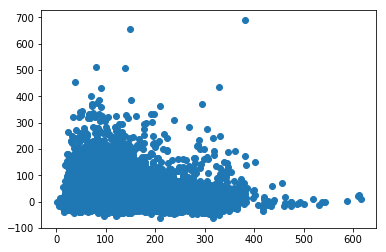

In [60]:
plt.scatter(dfq1.AirTime, dfq1.ArrDelay)

## Question 8 : 

* Consider the below bucketing logic for "Actual departure Time" :
    * Any flight departing between 4am - 12pm : Morning flight
    * Any flight departing between 12pm - 4pm : Afternoon flight
    * Any flight departing between 4pm - 9pm : Evening flight
    * Any flight departing between 9pm - 4am : Night flight
* Based on the above logic, answer the below questions : 
    * Which time of the day observes highest departure delays?
    * Create a pivot table with time of day in rows and type of delay in columns and #of occurrences in values
    * Which type of delay is most frequent in evening flights?
    * Which airport sees the highest occurrences of security related delay in the morning?

In [ ]:
# type your code below


## Question 9 :

* Consider the term "delay" as :
    * Any flight arriving more than 15 min later than the expected arrival time is considered "arrival delay"
    * Any flight departing more than 15 min later than the expected departure time is considered "departure delay"
    * A flight is considered delayed when any one of the above conditions is true
    * Based on the above, answer the below questions :
        * Which airline carriers have caused the highest % of delays?
        * Which airports are facing the highest % of delayed flights?

In [ ]:
# type your code below


## Question : 10

* List down top 10 cities in terms of total traffic between June and September
* Please note : Total traffic = Total #arrivals + Total #departures

In [ ]:
# type your code below
